In [7]:
import calflops

from utils import *

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

In [8]:
location = os.path.join("checkpoints", "PCAFormer")
config = Config().load(os.path.join(location, "config.json"))

In [9]:
if "cacheDir" in config:
    os.environ["KAGGLEHUB_CACHE"] = config.cacheDir

dataDir = download_dataset("dimensi0n/imagenet-256")

config.dataset.dataDir = dataDir

KaggleHub dataset path: F:/.cache/kagglehub\datasets\dimensi0n\imagenet-256\versions\1


In [10]:
def testModel(model, testSet, criterion: dict[str, nn.Module], name):
    model.eval()
    metrics = {}
    # Necessary for weighted mean
    weights = []
    flops, macs, params = None, None, None
    with torch.no_grad():
        progress = 0
        for inputs, targets in testSet:
            if flops is None:
                flops, macs, params = calflops.calculate_flops(model, input_shape=tuple(inputs.shape))

            outputs = model(inputs.to(device))
            for metric in criterion:
                if metric not in metrics:
                    metrics[metric] = []
                metrics[metric].append(criterion[metric](outputs, targets.to(device)).item())
            weights.append(inputs.shape[0])

            progress += 1
            print(f"\r{name} | {progress}/{len(testSet)} | Accuracy: {metrics['Accuracy'][-1]:.2f} | Perplexity: {metrics['Perplexity'][-1]:.2f}", end="")

    weights = np.array(weights)
    for metric in metrics:
        metrics[metric] = np.sum(np.array(metrics[metric]) * weights) / np.sum(weights)

    metrics["FLOPS"] = flops
    metrics["MACS"] = macs
    metrics["Params"] = params

    return metrics

In [11]:
class Accuracy(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, yPred, yTrue):
        indices = torch.argmax(yPred, dim=1)
        return torch.mean((indices == yTrue).float())


class Perplexity(nn.Module):
    def __init__(self):
        super().__init__()
        self.entropy = nn.CrossEntropyLoss()

    def forward(self, yPred, yTrue):
        log = self.entropy(yPred, yTrue)
        return torch.exp(log)

In [12]:
def loadPCA(x):
    pcaFormer = PCAFormer(config.model)
    pcaFormer.load_state_dict(torch.load(os.path.join(location, "checkpoint.pt")))
    return pcaFormer

loadResNet = lambda x: resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
loadSwin = lambda x: swin_v2_t(weights=Swin_V2_T_Weights.IMAGENET1K_V1)
loadVIT = lambda x: vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

modelLoaders = [loadPCA, loadResNet, loadSwin, loadVIT]
transforms = [None, ResNet50_Weights.IMAGENET1K_V1.transforms(), Swin_V2_T_Weights.IMAGENET1K_V1.transforms(),
              ViT_B_16_Weights.IMAGENET1K_V1.transforms()]
modelNames = ["PCAFormer", "ResNet50", "SwinTransformer-Tiny", "ViT-Base-16"]
collectedMetrics = []

criterion = {"Accuracy": Accuracy(), "Perplexity": Perplexity()}

for m, modelLoader in enumerate(modelLoaders):
    loaders = get_dataloaders(config, device, transforms[m])
    currentModel = modelLoader(None)
    modelMetrics = testModel(currentModel, loaders["val"], criterion, modelNames[m])
    collectedMetrics.append(modelMetrics)


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  38.92 M 
fwd MACs:                                                               677.23 GMACs
fwd FLOPs:                                                              1.36 TFLOPS
fwd+bwd MACs:                                                           2.03 TMACs
fwd+bwd FLOPs:                                                          4.08 TFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module cacul

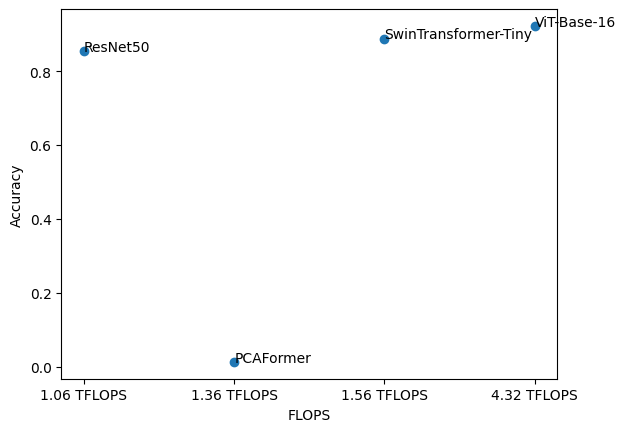

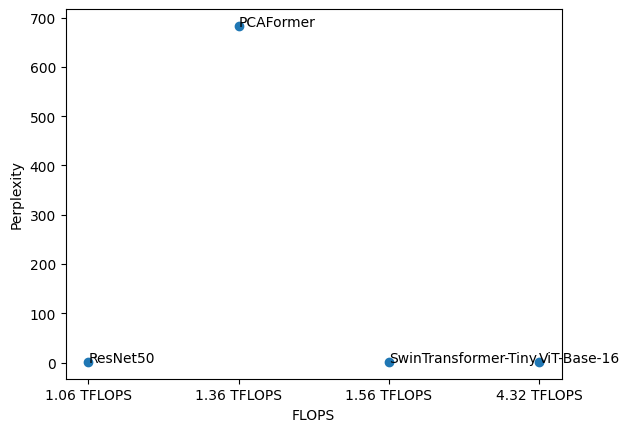

In [18]:
import pandas as pd

flops = [collectedMetric["FLOPS"] for collectedMetric in collectedMetrics]
for metric in criterion:
    measure = [collectedMetric[metric] for collectedMetric in collectedMetrics]

    data = pd.DataFrame({"FLOPS": flops, "measure": measure})
    data = data.sort_values("FLOPS")

    fig, ax = plt.subplots()
    ax.scatter(data["FLOPS"], data["measure"])
    ax.set_ylabel(metric)
    ax.set_xlabel("FLOPS")

    for i, name in enumerate(modelNames):
        ax.annotate(name, (flops[i], measure[i]))

In [ ]:
print(collectedMetrics)

In [ ]:
def getAttentionMatrices(m):
    attentionMatrices = {}

    def captureAttention(name):
        def hook(module, input, output):
            attentionWeights = output[1]
            attentionMatrices[name] = attentionWeights

        return hook

    loaders = get_dataloaders(config, device, transforms[m])
    currentModel = modelLoaders[m](None)
    handles = []
    if m == 3:
        for i, block in enumerate(currentModel.encoder.layers):
            hookHandle = block.self_attention.register_forward_hook(captureAttention(f"layer_{i}"))
            handles.append(hookHandle)
    else:
        for i, block in enumerate(currentModel.transformer.children()):
            hookHandle = block.attn.register_forward_hook(captureAttention(f"layer_{i}"))
            handles.append(hookHandle)

    inputs = next(iter(loaders["val"]))[0][4, :, :, :].unsqueeze(0).to(device)
    print(inputs.shape)

    with torch.no_grad():
        _ = currentModel(inputs)

    for handle in handles:
        handle.remove()

    return inputs, attentionMatrices

In [ ]:
inputs, pcaMatrices = getAttentionMatrices(0)
plt.imshow(inputs.squeeze().permute(1, 2, 0).cpu())
plt.show()
for key, value in pcaMatrices.items():
    print(key, value)
    plt.imshow(value[:, 0].cpu())
    plt.colorbar()
    plt.show()